In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string
from scipy import stats

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

from lifelines import CoxPHFitter

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.util import Surv
from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans

import scipy.cluster.hierarchy as shc

/Users/abbieschindler/opt/anaconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## read in and create dfs 

### demogs

In [35]:
path_demogs = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Clinical projects/SLS/data/SLS_demogs.xlsx'

demogs = pd.read_excel(path_demogs)

demogs = demogs.replace({-888: np.nan, 'Not Recorded': np.nan, -999: np.nan, ' .': np.nan, '.': np.nan})

print(demogs.shape)
print(len(demogs['SLS #'].unique()))

demogs.sort_values('SLS #').head()

(1104, 14)
1104


,SLS #,BIRTHYR,COHORT,DEATHYR,Age at first test condition,Year of Last Test,Age at Last testing Condition,Ethnicity,GENDER (m=1),APOE Status,Education,HBQ Median Sleep Duration,Average Sleep,Median Sleep
949,101530,1915,5,2006.0,62,2004,89,NaN,1,3/3,12,long_sleeper,7.333333,8.0
860,101910,1919,5,2008.0,58,2005,86,1.0,1,3/3,14,long_sleeper,9.000000,9.0
1056,111101,1911,4,2009.0,66,2005,94,1.0,1,2/3,8,medium_sleeper,6.666667,7.0
998,111401,1914,5,2005.0,63,2004,90,1.0,1,3/4,14,short_sleeper,6.500000,6.5
529,111702,1917,5,2010.0,60,1993,76,6.0,1,3/3,12,long_sleeper,8.000000,8.0


### sleep

In [36]:
path_sleep = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Clinical projects/SLS/data/SLS_sleep.xlsx'

sleep = pd.read_excel(path_sleep)

sleep = sleep.replace({-888: np.nan, 'Not Recorded': np.nan, -999: np.nan, ' .': np.nan, '.': np.nan})

print(sleep.shape)
print(len(sleep['SLS_ID'].unique()))

sleep.sort_values('SLS_ID').head()

(1104, 6)
1104


,SLS_ID,1993_sleep,1998_sleep,2005_sleep,2008_sleep,2012_sleep
665,101530,8.0,8.0,6.0,NaN,NaN
666,101910,9.0,9.0,NaN,NaN,NaN
318,111101,7.0,6.0,7.0,NaN,NaN
1005,111401,6.0,7.0,NaN,NaN,NaN
1006,111702,8.0,NaN,NaN,NaN,NaN


### health

In [37]:
path_health = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Clinical projects/SLS/data/SLS_health.xlsx'

health = pd.read_excel(path_health)

health = health.replace({-888: np.nan, 'Not Recorded': np.nan, -999: np.nan, ' .': np.nan, '.': np.nan})

print(health.shape)
print(len(health['SLS #'].unique()))

health.sort_values('SLS #').head()

(1104, 26)
1104


,SLS #,BMI 1993,BMI 1998,BMI 2005,BMI 2008,BMI 2012,DIABTS 1993,DIABTS 1998,DIABTS 2005,DIABTS 2008,DIABTS 2012,HTN 1993,HTN 1998,HTN 2005,HTN 2008,HTN 2012,SMOKYN 93,SMOKYN 98,SMOKYN 2005,SMOKYN 2008,SMOKYN 2012,USEALC 93,USEALC 98,USEALC 2005,USEALC 2008,USEALC 2012
3,101530,NaN,32.078031,29.288637,16.736364,16.736364,NaN,2.0,2.0,2.0,NaN,1.0,1.0,1.0,NaN,NaN,2.0,2.0,2.0,NaN,NaN,3.0,3.0,3.0,NaN,NaN
703,101910,NaN,29.649226,31.017652,29.534416,NaN,NaN,2.0,2.0,2.0,NaN,2.0,2.0,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,7.0,7.0,NaN,NaN,NaN
148,111101,21.894813,22.807097,23.806226,23.806226,23.887484,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,NaN,NaN,2.0,2.0,2.0,NaN,NaN,5.0,4.0,2.0,NaN,NaN
1014,111401,26.580974,25.848043,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
687,111702,NaN,25.726782,27.124489,27.802602,NaN,NaN,2.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN


### cog testing and depression


In [38]:
path_cognition = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Clinical projects/SLS/data/SLS_cog_dep.xlsx'

cognition = pd.read_excel(path_cognition)

cognition = cognition.replace({-888: np.nan, 'Not Recorded': np.nan, -999: np.nan, ' .': np.nan, '.': np.nan})

print(len(cognition.dropna(subset=['OCCSN'], axis=0)['IDNUM'].unique()))

#drop rows with no data
cognition = cognition.dropna(subset=['OCCSNDT'], axis=0)

print(cognition.shape)
cognition.head()

1104
(3729, 18)


,IDNUM,OCCSN,OCCSNDT,MMSE TOTAL,MATTIS TOTAL,TRAIL B,WAASV - Vocabulary Age-Scaled Score,WAASC - Comprehension Age-Scaled Score,WAASBD - Block Design Age-Scaled Score,WAASSY Digit-Symbol Age-Scaled Score,Any score ≤ 8 / Lowest Score,Dementia Criteria MMSE ≤ 27,Dementia Criteria MATTIS ≤ 130,Dementia Criteria Trail B ≥ 180,Dementia Criteria WAIS ≤ 8,Dementia Criteria Met,CESD-11 Restlessness,CESD Total Score
0,101530,1,1998.0,30.0,139.0,118.0,13.0,12.0,14.0,11.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
1,101530,2,2001.0,28.0,141.0,101.0,14.0,14.0,14.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0
2,101530,3,2004.0,29.0,139.0,73.0,17.0,14.0,10.0,13.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
7,101910,1,2001.0,27.0,135.0,274.0,10.0,10.0,10.0,11.0,10.0,1.0,0.0,1.0,0.0,2.0,0.0,7.0
8,101910,2,2005.0,26.0,126.0,192.0,9.0,12.0,7.0,9.0,7.0,1.0,1.0,1.0,1.0,4.0,0.0,6.0


### pathology

In [39]:
path_pathology = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Clinical projects/SLS/data/SLS_pathology.xlsx'

pathology = pd.read_excel(path_pathology)

pathology = pathology.replace({-888: np.nan, 'Not Recorded': np.nan, -999: np.nan, ' .': np.nan, '.': np.nan})

print(pathology.shape)
pathology.head()

(105, 17)


,SLS #,NP #,BIRTHYR,COHORT,DEATHYR,Age at Death,Age at first test condition,Year of Last Test,Age at Last Test,GENDER,APOE Status,Education,HBQ Median Sleep Duration,CERAD SCORE,CERAD BOOL,BRAAK,BRAAK BOOL
0,134513,11-0708,1907,4,2011,104,49,2007,100,2,3/3,18,long_sleeper,1,0,0,0
1,135023,06-1461,1915,5,2006,91,41,2005,90,1,2/3,12,long_sleeper,3,1,2,0
2,136010,08-0908,1927,6,2008,81,29,2008,81,1,3/3,16,medium_sleeper,3,1,6,1
3,136515,10-0562,1924,6,2010,85,32,2010,86,2,3/3,18,long_sleeper,1,0,0,0
4,136524,15-1425,1926,6,2015,89,30,2011,85,2,2/3,18,long_sleeper,3,1,0,0


## add demogs and depression

### demogs


In [40]:
#add in birth year from demogs
demogs_pathology = pd.merge(pathology, demogs[['SLS #', 
                                          'Ethnicity', ]], on=['SLS #'], sort=False)

print(demogs_pathology.shape)
demogs_pathology.head()

(105, 18)


,SLS #,NP #,BIRTHYR,COHORT,DEATHYR,Age at Death,Age at first test condition,Year of Last Test,Age at Last Test,GENDER,APOE Status,Education,HBQ Median Sleep Duration,CERAD SCORE,CERAD BOOL,BRAAK,BRAAK BOOL,Ethnicity
0,134513,11-0708,1907,4,2011,104,49,2007,100,2,3/3,18,long_sleeper,1,0,0,0,1.0
1,135023,06-1461,1915,5,2006,91,41,2005,90,1,2/3,12,long_sleeper,3,1,2,0,1.0
2,136010,08-0908,1927,6,2008,81,29,2008,81,1,3/3,16,medium_sleeper,3,1,6,1,1.0
3,136515,10-0562,1924,6,2010,85,32,2010,86,2,3/3,18,long_sleeper,1,0,0,0,1.0
4,136524,15-1425,1926,6,2015,89,30,2011,85,2,2/3,18,long_sleeper,3,1,0,0,1.0


### depression from most recent data point to death


In [41]:
#get list of pathology IDs
ID_list = demogs_pathology['SLS #'].unique()
#filter cognition by IDs
cognition_short = cognition[cognition['IDNUM'].isin(ID_list)]
print(cognition_short.shape)

(388, 18)


In [42]:
#find final visit for each ID and use to get corr depression data
id_occ = cognition_short.groupby(['IDNUM'])['OCCSNDT'].max().reset_index()
id_occ_depp = pd.merge(id_occ, cognition[['IDNUM', 'OCCSNDT', 'CESD-11 Restlessness', 'CESD Total Score']], 
         on=['IDNUM', 'OCCSNDT'], sort=False).sort_values('IDNUM')

demogs_pathology = demogs_pathology.sort_values('SLS #')
demogs_pathology['CESD-11 Restlessness'] = id_occ_depp['CESD-11 Restlessness']
demogs_pathology['CESD Total Score'] = id_occ_depp['CESD Total Score']

print(demogs_pathology.shape)

demogs_pathology.head()

(105, 20)


,SLS #,NP #,BIRTHYR,COHORT,DEATHYR,Age at Death,Age at first test condition,Year of Last Test,Age at Last Test,GENDER,APOE Status,Education,HBQ Median Sleep Duration,CERAD SCORE,CERAD BOOL,BRAAK,BRAAK BOOL,Ethnicity,CESD-11 Restlessness,CESD Total Score
0,134513,11-0708,1907,4,2011,104,49,2007,100,2,3/3,18,long_sleeper,1,0,0,0,1.0,2.0,15.0
1,135023,06-1461,1915,5,2006,91,41,2005,90,1,2/3,12,long_sleeper,3,1,2,0,1.0,0.0,10.0
2,136010,08-0908,1927,6,2008,81,29,2008,81,1,3/3,16,medium_sleeper,3,1,6,1,1.0,1.0,1.0
3,136515,10-0562,1924,6,2010,85,32,2010,86,2,3/3,18,long_sleeper,1,0,0,0,1.0,NaN,NaN
4,136524,15-1425,1926,6,2015,89,30,2011,85,2,2/3,18,long_sleeper,3,1,0,0,1.0,1.0,11.0


## Compute sleep and health data


In [43]:
demogs_pathology = demogs_pathology.infer_objects()

### compute sleep data (up to and including visit dementia yes/no)


In [44]:
sleep_count = []
sleep_count_final = []
sleep_keep = []

sleep_first = []
sleep_last = []

sleep_mean = []
sleep_median = []
sleep_std = []
sleep_slope = []
sleep_slope_int = []
sleep_slope_r = []
sleep_slope_p = []
sleep_slope_stderr = []

sleep_params = ['1993_sleep', '1998_sleep', '2005_sleep', '2008_sleep', '2012_sleep',]

for index, row in demogs_pathology.iterrows():
    
    #figure out how many sleep values to keep (only up to/including their dementia yes/no tp)
    if row['DEATHYR'] >= 2012:
        count = 5
    elif (row['DEATHYR'] >= 2008) & (row['DEATHYR'] < 2012):
        count = 4
    elif (row['DEATHYR'] >= 2005) & (row['DEATHYR'] < 2008):
        count = 3
    elif (row['DEATHYR'] >= 1998) & (row['DEATHYR'] < 2005):
        count = 2
    elif (row['DEATHYR'] >= 1993) & (row['DEATHYR'] < 1998):
        count = 1
    elif row['DEATHYR'] < 1993:
        count = 0
        
    sleep_count.append(count)   

    #get sleep data up to and including final time point (dementia yes/no)
    d_sleep = sleep[sleep['SLS_ID'] == row['SLS #']][sleep_params[0:count]].dropna(axis=1)
    #get count of how many sleep data points were used (sleep count above might include nans)
    sleep_count_final.append(d_sleep.shape[1])
    
    #compute sleep params - requires at least 2 
    if d_sleep.shape[1] < 3:
        sleep_keep.append(0)
        sleep_first.append(np.nan)
        sleep_last.append(np.nan)
        sleep_mean.append(np.nan)
        sleep_median.append(np.nan)
        sleep_std.append(np.nan)
        sleep_slope.append(np.nan)
        sleep_slope_int.append(np.nan)
        sleep_slope_r.append(np.nan)
        sleep_slope_p.append(np.nan)
        sleep_slope_stderr.append(np.nan)
    else:
        sleep_keep.append(1)
        sleep_first.append(d_sleep.values[0][0])
        sleep_last.append(d_sleep.values[0][-1])
        sleep_mean.append(d_sleep.mean(axis=1).values[0])
        sleep_median.append(d_sleep.median(axis=1).values[0])
        sleep_std.append(d_sleep.std(axis=1).values[0])
        
        y=list(d_sleep.values[0])
        x=list(np.arange(0,len(y)))
        slope = stats.linregress(x, y)
        sleep_slope.append(slope[0])
        sleep_slope_int.append(slope[1])
        sleep_slope_r.append(slope[2])
        sleep_slope_p.append(slope[3])
        sleep_slope_stderr.append(slope[4])

demogs_pathology['sleep_keep'] = sleep_keep    
demogs_pathology['sleep_count'] = sleep_count
demogs_pathology['sleep_count_final'] = sleep_count_final
demogs_pathology['sleep_first'] = sleep_first
demogs_pathology['sleep_last'] = sleep_last
demogs_pathology['sleep_mean'] = sleep_mean
demogs_pathology['sleep_median'] = sleep_median
demogs_pathology['sleep_std'] = sleep_std
demogs_pathology['sleep_slope'] = sleep_slope
demogs_pathology['sleep_slope_int'] = sleep_slope_int
demogs_pathology['sleep_slope_r'] = sleep_slope_r
demogs_pathology['sleep_slope_p'] = sleep_slope_p
demogs_pathology['sleep_slope_stderr'] = sleep_slope_stderr


print(demogs_pathology.shape)
demogs_pathology.head()

(105, 33)


,SLS #,NP #,BIRTHYR,COHORT,DEATHYR,Age at Death,Age at first test condition,Year of Last Test,Age at Last Test,GENDER,APOE Status,Education,HBQ Median Sleep Duration,CERAD SCORE,CERAD BOOL,BRAAK,BRAAK BOOL,Ethnicity,CESD-11 Restlessness,CESD Total Score,sleep_keep,sleep_count,sleep_count_final,sleep_first,sleep_last,sleep_mean,sleep_median,sleep_std,sleep_slope,sleep_slope_int,sleep_slope_r,sleep_slope_p,sleep_slope_stderr
0,134513,11-0708,1907,4,2011,104,49,2007,100,2,3/3,18,long_sleeper,1,0,0,0,1.0,2.0,15.0,1,4,3,8.0,8.0,8.000000,8.0,0.000000,0.0,8.000000,0.000000,1.000000,0.000000
1,135023,06-1461,1915,5,2006,91,41,2005,90,1,2/3,12,long_sleeper,3,1,2,0,1.0,0.0,10.0,1,3,3,6.0,8.0,7.333333,8.0,1.154701,1.0,6.333333,0.866025,0.333333,0.577350
2,136010,08-0908,1927,6,2008,81,29,2008,81,1,3/3,16,medium_sleeper,3,1,6,1,1.0,1.0,1.0,1,4,4,8.0,7.0,7.000000,7.0,0.816497,-0.4,7.600000,-0.632456,0.367544,0.346410
3,136515,10-0562,1924,6,2010,85,32,2010,86,2,3/3,18,long_sleeper,1,0,0,0,1.0,NaN,NaN,1,4,4,8.0,6.0,7.750000,8.0,1.258306,-0.5,8.500000,-0.512989,0.487011,0.591608
4,136524,15-1425,1926,6,2015,89,30,2011,85,2,2/3,18,long_sleeper,3,1,0,0,1.0,1.0,11.0,1,5,5,8.0,8.0,7.800000,8.0,0.447214,-0.1,8.000000,-0.353553,0.559404,0.152753


In [45]:
demogs_pathology.groupby(['BRAAK BOOL'])['sleep_keep'].value_counts()

BRAAK BOOL  sleep_keep
0           1             25
            0             7 
1           1             62
            0             11
Name: sleep_keep, dtype: int64

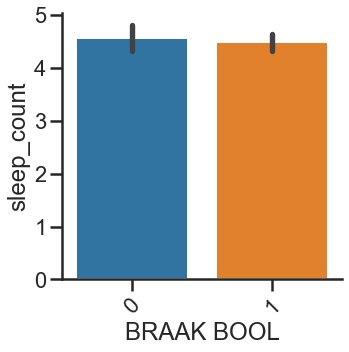

In [46]:
sns.catplot(x='BRAAK BOOL', y='sleep_count', data=demogs_pathology[demogs_pathology['sleep_keep']==1], kind='bar',)
plt.xticks(rotation = 45)
plt.show()

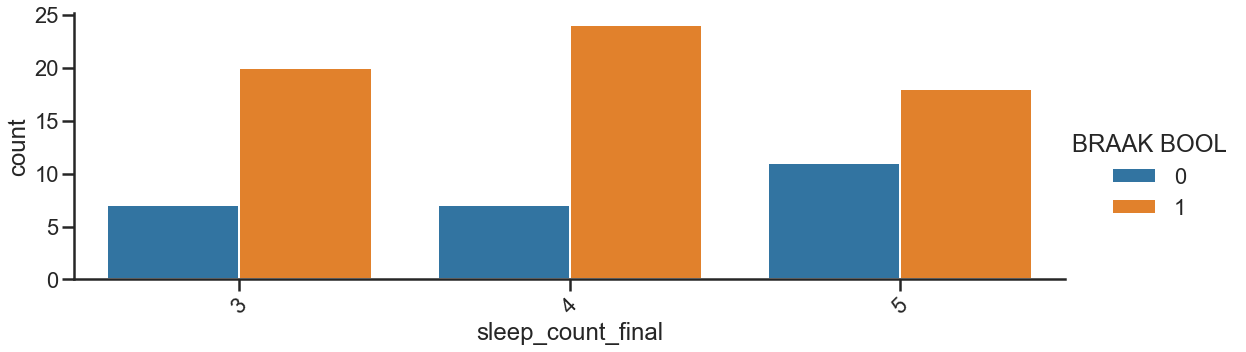

In [47]:
sleep_counts = demogs_pathology[demogs_pathology['sleep_keep']==1].groupby('sleep_count_final')['BRAAK BOOL'].value_counts().reset_index(name='count')
sns.catplot(x='sleep_count_final', y='count', data=sleep_counts, kind='bar', hue='BRAAK BOOL', height=5, aspect=3)
plt.xticks(rotation = 45)
plt.show()

### get health data corresponding to visit with dementia yes/no


In [48]:
BMI = []
DIABTS = []
HTN = []
SMOKING = []
ALCOHOL = []

BMI_params = ['BMI 1993', 'BMI 1998', 'BMI 2005', 'BMI 2008', 'BMI 2012',]
DIABTS_params = ['DIABTS 1993', 'DIABTS 1998', 'DIABTS 2005', 'DIABTS 2008', 'DIABTS 2012',]
HTN_params = ['HTN 1993', 'HTN 1998', 'HTN 2005', 'HTN 2008', 'HTN 2012',]
SMOKING_params = ['SMOKYN 93', 'SMOKYN 98', 'SMOKYN 2005', 'SMOKYN 2008', 'SMOKYN 2012']
ALCOHOL_params = ['USEALC 93', 'USEALC 98', 'USEALC 2005', 'USEALC 2008', 'USEALC 2012']

for index, row in demogs_pathology.iterrows():
    
    #get which visit is the final data point (same as sleep count (number of visits including the dementia yes/no))
    sleep_count = row['sleep_count']
    #print(sleep_count)
    
    #get data for final time point (dementia yes/no)
    d_int = health[health['SLS #'] == row['SLS #']]
    #print(d_int)
    
    BMI.append(d_int[BMI_params[sleep_count - 1]].values[0])
    DIABTS.append(d_int[DIABTS_params[sleep_count - 1]].values[0])
    HTN.append(d_int[HTN_params[sleep_count - 1]].values[0])
    SMOKING.append(d_int[SMOKING_params[sleep_count - 1]].values[0])
    ALCOHOL.append(d_int[ALCOHOL_params[sleep_count - 1]].values[0])

demogs_pathology['BMI'] = BMI    
demogs_pathology['DIABTS'] = DIABTS
demogs_pathology['HTN'] = HTN
demogs_pathology['SMOKING'] = SMOKING
demogs_pathology['ALCOHOL'] = ALCOHOL

print(demogs_pathology.shape)
demogs_pathology.head()

(105, 38)


,SLS #,NP #,BIRTHYR,COHORT,DEATHYR,Age at Death,Age at first test condition,Year of Last Test,Age at Last Test,GENDER,APOE Status,Education,HBQ Median Sleep Duration,CERAD SCORE,CERAD BOOL,BRAAK,BRAAK BOOL,Ethnicity,CESD-11 Restlessness,CESD Total Score,sleep_keep,sleep_count,sleep_count_final,sleep_first,sleep_last,sleep_mean,sleep_median,sleep_std,sleep_slope,sleep_slope_int,sleep_slope_r,sleep_slope_p,sleep_slope_stderr,BMI,DIABTS,HTN,SMOKING,ALCOHOL
0,134513,11-0708,1907,4,2011,104,49,2007,100,2,3/3,18,long_sleeper,1,0,0,0,1.0,2.0,15.0,1,4,3,8.0,8.0,8.000000,8.0,0.000000,0.0,8.000000,0.000000,1.000000,0.000000,34.542207,2.0,NaN,NaN,NaN
1,135023,06-1461,1915,5,2006,91,41,2005,90,1,2/3,12,long_sleeper,3,1,2,0,1.0,0.0,10.0,1,3,3,6.0,8.0,7.333333,8.0,1.154701,1.0,6.333333,0.866025,0.333333,0.577350,22.315152,1.0,1.0,2.0,4.0
2,136010,08-0908,1927,6,2008,81,29,2008,81,1,3/3,16,medium_sleeper,3,1,6,1,1.0,1.0,1.0,1,4,4,8.0,7.0,7.000000,7.0,0.816497,-0.4,7.600000,-0.632456,0.367544,0.346410,36.618061,1.0,1.0,2.0,2.0
3,136515,10-0562,1924,6,2010,85,32,2010,86,2,3/3,18,long_sleeper,1,0,0,0,1.0,NaN,NaN,1,4,4,8.0,6.0,7.750000,8.0,1.258306,-0.5,8.500000,-0.512989,0.487011,0.591608,21.287299,2.0,2.0,3.0,2.0
4,136524,15-1425,1926,6,2015,89,30,2011,85,2,2/3,18,long_sleeper,3,1,0,0,1.0,1.0,11.0,1,5,5,8.0,8.0,7.800000,8.0,0.447214,-0.1,8.000000,-0.353553,0.559404,0.152753,24.210288,NaN,2.0,3.0,3.0


## Survival curves


### Only use participants with slope data (at least 3 sleep data point)


In [61]:
demogs_pathology_sleep = demogs_pathology[demogs_pathology['sleep_keep']==1]

print(demogs_pathology.shape)
print(demogs_pathology_sleep.shape)

demogs_pathology_sleep.head()

(105, 38)
(87, 38)


,SLS #,NP #,BIRTHYR,COHORT,DEATHYR,Age at Death,Age at first test condition,Year of Last Test,Age at Last Test,GENDER,APOE Status,Education,HBQ Median Sleep Duration,CERAD SCORE,CERAD BOOL,BRAAK,BRAAK BOOL,Ethnicity,CESD-11 Restlessness,CESD Total Score,sleep_keep,sleep_count,sleep_count_final,sleep_first,sleep_last,sleep_mean,sleep_median,sleep_std,sleep_slope,sleep_slope_int,sleep_slope_r,sleep_slope_p,sleep_slope_stderr,BMI,DIABTS,HTN,SMOKING,ALCOHOL
0,134513,11-0708,1907,4,2011,104,49,2007,100,2,3/3,18,long_sleeper,1,0,0,0,1.0,2.0,15.0,1,4,3,8.0,8.0,8.000000,8.0,0.000000,0.0,8.000000,0.000000,1.000000,0.000000,34.542207,2.0,NaN,NaN,NaN
1,135023,06-1461,1915,5,2006,91,41,2005,90,1,2/3,12,long_sleeper,3,1,2,0,1.0,0.0,10.0,1,3,3,6.0,8.0,7.333333,8.0,1.154701,1.0,6.333333,0.866025,0.333333,0.577350,22.315152,1.0,1.0,2.0,4.0
2,136010,08-0908,1927,6,2008,81,29,2008,81,1,3/3,16,medium_sleeper,3,1,6,1,1.0,1.0,1.0,1,4,4,8.0,7.0,7.000000,7.0,0.816497,-0.4,7.600000,-0.632456,0.367544,0.346410,36.618061,1.0,1.0,2.0,2.0
3,136515,10-0562,1924,6,2010,85,32,2010,86,2,3/3,18,long_sleeper,1,0,0,0,1.0,NaN,NaN,1,4,4,8.0,6.0,7.750000,8.0,1.258306,-0.5,8.500000,-0.512989,0.487011,0.591608,21.287299,2.0,2.0,3.0,2.0
4,136524,15-1425,1926,6,2015,89,30,2011,85,2,2/3,18,long_sleeper,3,1,0,0,1.0,1.0,11.0,1,5,5,8.0,8.0,7.800000,8.0,0.447214,-0.1,8.000000,-0.353553,0.559404,0.152753,24.210288,NaN,2.0,3.0,3.0


In [62]:
data_final = demogs_pathology_sleep[['SLS #', 'BIRTHYR', 'COHORT',  
                     'Ethnicity', 'GENDER', 'APOE Status', 'Education', 'Age at Death', 
                                     'CERAD SCORE', 'CERAD BOOL', 'BRAAK', 'BRAAK BOOL',
                                     'sleep_keep', 'sleep_count',
       'sleep_count_final', 'sleep_first', 'sleep_last', 'sleep_mean',
       'sleep_median', 'sleep_std', 'sleep_slope', 'sleep_slope_int',
       'sleep_slope_r', 'sleep_slope_p', 'sleep_slope_stderr',
                                   'CESD-11 Restlessness', 'CESD Total Score']]

print(data_final.shape)
data_final.head()

(87, 27)


,SLS #,BIRTHYR,COHORT,Ethnicity,GENDER,APOE Status,Education,Age at Death,CERAD SCORE,CERAD BOOL,BRAAK,BRAAK BOOL,sleep_keep,sleep_count,sleep_count_final,sleep_first,sleep_last,sleep_mean,sleep_median,sleep_std,sleep_slope,sleep_slope_int,sleep_slope_r,sleep_slope_p,sleep_slope_stderr,CESD-11 Restlessness,CESD Total Score
0,134513,1907,4,1.0,2,3/3,18,104,1,0,0,0,1,4,3,8.0,8.0,8.000000,8.0,0.000000,0.0,8.000000,0.000000,1.000000,0.000000,2.0,15.0
1,135023,1915,5,1.0,1,2/3,12,91,3,1,2,0,1,3,3,6.0,8.0,7.333333,8.0,1.154701,1.0,6.333333,0.866025,0.333333,0.577350,0.0,10.0
2,136010,1927,6,1.0,1,3/3,16,81,3,1,6,1,1,4,4,8.0,7.0,7.000000,7.0,0.816497,-0.4,7.600000,-0.632456,0.367544,0.346410,1.0,1.0
3,136515,1924,6,1.0,2,3/3,18,85,1,0,0,0,1,4,4,8.0,6.0,7.750000,8.0,1.258306,-0.5,8.500000,-0.512989,0.487011,0.591608,NaN,NaN
4,136524,1926,6,1.0,2,2/3,18,89,3,1,0,0,1,5,5,8.0,8.0,7.800000,8.0,0.447214,-0.1,8.000000,-0.353553,0.559404,0.152753,1.0,11.0


In [63]:
covariates = ['Education', 'APOE Status', 'GENDER', 'Ethnicity',
             'CESD-11 Restlessness', 'CESD Total Score', ]

for param in covariates:
    print(param, ' missing: ', data_final[param].isna().sum())

Education  missing:  0
APOE Status  missing:  8
GENDER  missing:  0
Ethnicity  missing:  3
CESD-11 Restlessness  missing:  4
CESD Total Score  missing:  4


In [64]:
data_final_nona = data_final.dropna(axis=0)
print(data_final_nona.shape)
data_final_nona.isna().sum()

(72, 27)


SLS #                   0
BIRTHYR                 0
COHORT                  0
Ethnicity               0
GENDER                  0
APOE Status             0
Education               0
Age at Death            0
CERAD SCORE             0
CERAD BOOL              0
BRAAK                   0
BRAAK BOOL              0
sleep_keep              0
sleep_count             0
sleep_count_final       0
sleep_first             0
sleep_last              0
sleep_mean              0
sleep_median            0
sleep_std               0
sleep_slope             0
sleep_slope_int         0
sleep_slope_r           0
sleep_slope_p           0
sleep_slope_stderr      0
CESD-11 Restlessness    0
CESD Total Score        0
dtype: int64

### Clean and update covariates


In [65]:
print(data_final_nona['APOE Status'].value_counts())

data_final_nona['APOE_bool'] = [1 if '4' in str(x).split('/') else 0 for x in data_final_nona['APOE Status']]

print(data_final_nona['APOE_bool'].value_counts())

3/3    43
3/4    18
2/3    8 
4/4    2 
2/4    1 
Name: APOE Status, dtype: int64
0    51
1    21
Name: APOE_bool, dtype: int64


In [66]:
print(data_final_nona['Ethnicity'].value_counts())

data_final_nona['Ethnicity_bool'] = [1 if x==1 else 0 for x in data_final_nona['Ethnicity']]

print(data_final_nona['Ethnicity_bool'].value_counts())

1.0    70
3.0    1 
6.0    1 
Name: Ethnicity, dtype: int64
1    70
0    2 
Name: Ethnicity_bool, dtype: int64


In [67]:
data_final_nona = data_final_nona.infer_objects()
print(data_final_nona.dtypes)

SLS #                   int64  
BIRTHYR                 int64  
COHORT                  int64  
Ethnicity               float64
GENDER                  int64  
APOE Status             object 
Education               int64  
Age at Death            int64  
CERAD SCORE             int64  
CERAD BOOL              int64  
BRAAK                   int64  
BRAAK BOOL              int64  
sleep_keep              int64  
sleep_count             int64  
sleep_count_final       int64  
sleep_first             float64
sleep_last              float64
sleep_mean              float64
sleep_median            float64
sleep_std               float64
sleep_slope             float64
sleep_slope_int         float64
sleep_slope_r           float64
sleep_slope_p           float64
sleep_slope_stderr      float64
CESD-11 Restlessness    float64
CESD Total Score        float64
APOE_bool               int64  
Ethnicity_bool          int64  
dtype: object


### Cox PH 


#### base model


In [56]:
from lifelines import CoxPHFitter

data_simple = data_final_nona[['BRAAK BOOL', 'Age at Death',
                               'GENDER', 'Education',  'APOE_bool', 'Ethnicity_bool',
                              ]]
cph = CoxPHFitter()
cph.fit(data_simple, duration_col='Age at Death', event_col='BRAAK BOOL')

cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 72 total observations, 23 right-censored observations>
             duration col = 'Age at Death'
                event col = 'BRAAK BOOL'
      baseline estimation = breslow
   number of observations = 72
number of events observed = 49
   partial log-likelihood = -160.97
         time fit was run = 2021-11-20 01:37:55 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
GENDER          -0.11       0.90       0.29            -0.69             0.47                 0.50                 1.60
Education        0.01       1.01       0.06            -0.11             0.13                 0.90                 1.14
APOE_bool        0.15       1.16       0.32            -0.49             0.78                 0.61                 2.18
Ethnicity_bool  15.88   7.87e+06    2928.74         -5724.35          5756.10                 0.00                  inf

                   z    p   -log2(p)
covariate                           
GENDER         -0.37 0.71       0.49
Education       0.22 0.83       0.27
APOE_bool       0.45 0.65       0.62
Ethnicity_bool  0.01 1.00       0.01
---
Concordance = 0.52
Partial AIC = 329.95
log-likelihood ratio test = 2.11 on 4 df
-log2(p) of ll-ratio test = 0.48

#### add depression factors to model


In [57]:
data_simple = data_final_nona[['BRAAK BOOL', 'Age at Death',
                               'GENDER', 'Education',  'APOE_bool', 'Ethnicity_bool',
                               'CESD Total Score',
                              ]]
cph_dep = CoxPHFitter()
cph_dep.fit(data_simple, duration_col='Age at Death', event_col='BRAAK BOOL')

cph_dep.print_summary() 

<lifelines.CoxPHFitter: fitted with 72 total observations, 23 right-censored observations>
             duration col = 'Age at Death'
                event col = 'BRAAK BOOL'
      baseline estimation = breslow
   number of observations = 72
number of events observed = 49
   partial log-likelihood = -160.91
         time fit was run = 2021-11-20 01:37:56 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
GENDER            -0.16       0.85       0.33            -0.80             0.48                 0.45                 1.62
Education          0.02       1.02       0.06            -0.10             0.14                 0.90                 1.15
APOE_bool          0.13       1.14       0.33            -0.51             0.77                 0.60                 2.16
Ethnicity_bool    15.84   7.59e+06    2927.27         -5721.50          5753.18                 0.00                  inf
CESD Total Score  -0.01       0.99       0.02            -0.05             0.03                 0.95                 1.04

                     z    p   -log2(p)
covariate                             
GENDER           -0.49 0.63       0.67
Education         0.29 0.78       0.37
APOE_bool         0.39 0.70       0.52
Ethnicity_bool    0.01 1.00       0.01
CESD Total Score -0.36 0.72       0.47
---
Concordance = 0.54
Partial AIC = 331.82
log-likelihood ratio test = 2.23 on 5 df
-log2(p) of ll-ratio test = 0.29

#### add sleep factors to model


In [58]:
data_simple = data_final_nona[['BRAAK BOOL', 'Age at Death',
                               'GENDER', 'Education',  'APOE_bool', 'Ethnicity_bool',
                               'CESD Total Score',
                               'sleep_first', 'sleep_last', 'sleep_mean',
       'sleep_std', 'sleep_slope_int',
       'sleep_slope_r']]

cph_dep_sleep = CoxPHFitter()
cph_dep_sleep.fit(data_simple, duration_col='Age at Death', event_col='BRAAK BOOL')

cph_dep_sleep.print_summary() 

<lifelines.CoxPHFitter: fitted with 72 total observations, 23 right-censored observations>
             duration col = 'Age at Death'
                event col = 'BRAAK BOOL'
      baseline estimation = breslow
   number of observations = 72
number of events observed = 49
   partial log-likelihood = -156.07
         time fit was run = 2021-11-20 01:37:56 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
GENDER            -0.34       0.71       0.35            -1.03             0.35                 0.36                 1.42
Education          0.06       1.06       0.07            -0.07             0.19                 0.93                 1.21
APOE_bool          0.15       1.16       0.34            -0.51             0.81                 0.60                 2.24
Ethnicity_bool    15.72   6.70e+06    3066.76         -5995.03          6026.46                 0.00                  inf
CESD Total Score  -0.01       0.99       0.02            -0.06             0.03                 0.95                 1.03
sleep_first        0.25       1.29       0.59            -0.91             1.42                 0.40                 4.12
sleep_last        -0.21       0.81       0.48            -1.15             0.72                 0.32                 2.06
sleep_mean         1.18       3.26       1.37            -1.50             3.86                 0.22                47.56
sleep_std          0.55       1.73       0.45            -0.33             1.43                 0.72                 4.17
sleep_slope_int   -1.45       0.23       1.41            -4.22             1.31                 0.01                 3.70
sleep_slope_r     -1.68       0.19       0.85            -3.35            -0.01                 0.04                 0.99

                     z    p   -log2(p)
covariate                             
GENDER           -0.96 0.34       1.58
Education         0.88 0.38       1.40
APOE_bool         0.45 0.66       0.61
Ethnicity_bool    0.01 1.00       0.01
CESD Total Score -0.58 0.56       0.83
sleep_first       0.43 0.67       0.58
sleep_last       -0.44 0.66       0.61
sleep_mean        0.86 0.39       1.37
sleep_std         1.22 0.22       2.18
sleep_slope_int  -1.03 0.30       1.73
sleep_slope_r    -1.97 0.05       4.36
---
Concordance = 0.64
Partial AIC = 334.14
log-likelihood ratio test = 11.91 on 11 df
-log2(p) of ll-ratio test = 1.43

## predict 

In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_auc_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.neighbors import KNeighborsClassifier 
import xgboost as xgb

from sklearn.feature_selection import RFECV

import shap
# load JS visualization code to notebook
shap.initjs()

In [72]:
predict = data_final_nona[['BRAAK',  'CERAD SCORE', 'Age at Death',
                               'GENDER', 'Education',  'APOE_bool', 'Ethnicity_bool',
                         'sleep_first', 'sleep_last', 'sleep_mean', 'sleep_median',
       'sleep_std', 'sleep_slope', 'sleep_slope_int', 'sleep_slope_r',
       'sleep_slope_p', 'sleep_slope_stderr', 'CESD-11 Restlessness',
       'CESD Total Score',]]

print(predict.shape)
predict.head()

(72, 19)


,BRAAK,CERAD SCORE,Age at Death,GENDER,Education,APOE_bool,Ethnicity_bool,sleep_first,sleep_last,sleep_mean,sleep_median,sleep_std,sleep_slope,sleep_slope_int,sleep_slope_r,sleep_slope_p,sleep_slope_stderr,CESD-11 Restlessness,CESD Total Score
0,0,1,104,2,18,0,1,8.0,8.0,8.000000,8.0,0.000000,0.0,8.000000,0.000000,1.000000,0.000000,2.0,15.0
1,2,3,91,1,12,0,1,6.0,8.0,7.333333,8.0,1.154701,1.0,6.333333,0.866025,0.333333,0.577350,0.0,10.0
2,6,3,81,1,16,0,1,8.0,7.0,7.000000,7.0,0.816497,-0.4,7.600000,-0.632456,0.367544,0.346410,1.0,1.0
4,0,3,89,2,18,0,1,8.0,8.0,7.800000,8.0,0.447214,-0.1,8.000000,-0.353553,0.559404,0.152753,1.0,11.0
5,3,2,89,2,16,0,1,6.0,5.0,5.600000,5.0,0.894427,-0.4,6.400000,-0.707107,0.181690,0.230940,0.0,3.0


In [85]:
#split data
train, test = train_test_split(predict, test_size = .3, random_state=39, stratify = predict['CERAD SCORE'])

Y_train = train['CERAD SCORE']
Y_test = test['CERAD SCORE']

#create feature sets
features = ['Education', 'Age at Death',
                               'GENDER', 'Education',  'APOE_bool', 'Ethnicity_bool',
                         'sleep_first', 'sleep_last', 'sleep_mean', 
       'sleep_std', 'sleep_slope', 'sleep_slope_int',  'CESD-11 Restlessness',
       'CESD Total Score',]

X_train = train[features]
X_test = test[features]

#scale data algo
scaler = StandardScaler()

#k fold algo
strat_k_fold = StratifiedKFold(n_splits=10)

#scale data 
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.fit_transform(X_test)


In [89]:

# evaluate random forest algorithm for classification
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

# define the model
model = DummyRegressor()
model = RandomForestRegressor()
#model = AdaBoostRegressor()
#model = KNeighborsRegressor(n_neighbors=5)

# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=39)
n_scores = cross_val_score(model, train_scaled, Y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE = %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

reg = model.fit(train_scaled, Y_train)
print('R2 = ', reg.score(train_scaled, Y_train))

MAE = -0.849 (0.216)
R2 =  0.8739440659734672


In [90]:
#scale data for grid search
explainer = shap.KernelExplainer(model.predict, train_scaled)
shap_values = explainer.shap_values(train_scaled)

  0%|          | 0/50 [00:00<?, ?it/s]

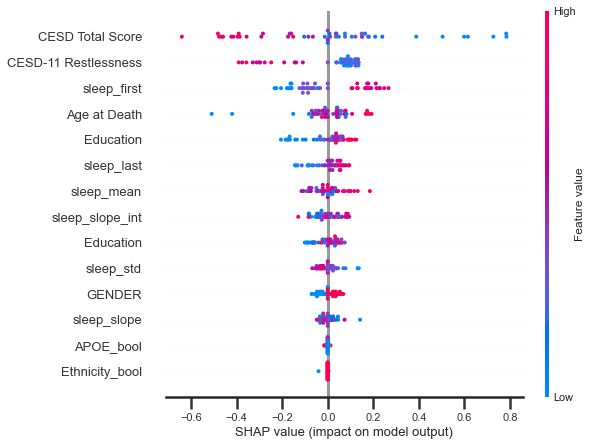

In [91]:
shap.summary_plot(shap_values, X_train)

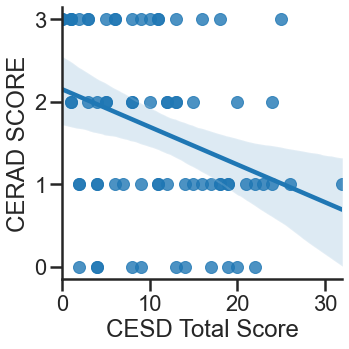

In [96]:
sns.lmplot(x='CESD Total Score', y='CERAD SCORE', data=predict)

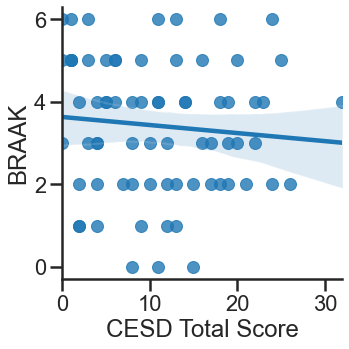

In [93]:
sns.lmplot(x='CESD Total Score', y='BRAAK', data=predict)